# Predicting heart disease using machine learning

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting whether or not someone has heart disease based on their medical attributes.

We're going to take the following approach:

Problem definition
Data
Evaluation
Features
Modelling
Experimentation

### Problem Definition¶
In a statement,

Given clinical parameters about a patient, can we predict whether or not they have heart disease?

### Data¶
The original data came from the Cleavland data from the UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/heart+Disease

There is also a version of it available on Kaggle. https://www.kaggle.com/ronitf/heart-disease-uci


### Features¶
This is where you'll get different information about each of the features in your data. You can do this via doing your own research (such as looking at the links above) or by talking to a subject matter expert (someone who knows about the dataset).

**Create data dictionary**

1. age - age in years
2. sex - (1 = male; 0 = female)
3. cp - chest pain type
    0: Typical angina: chest pain related decrease blood supply to the heart
    1: Atypical angina: chest pain not related to heart
    2: Non-anginal pain: typically esophageal spasms (non heart related)
    3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital) anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl
    - serum = LDL + HDL + .2 * triglycerides
    - above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    - '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    0: Nothing to note
    1: ST-T Wave abnormality
        - can range from mild symptoms to severe problems
        - signals non-normal heart beat
    2: Possible or definite left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved
9. exang - exercise induced angina (1 = yes; 0 = no)
10. oldpeak - ST depression induced by exercise relative to rest looks at stress of heart during excercise unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    0: Upsloping: better heart rate with excercise (uncommon)
    1: Flatsloping: minimal change (typical healthy heart)
    2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy
    - colored vessel means the doctor can see the blood passing through
    - the more blood movement the better (no clots)
13. thal - thalium stress result
    - 1,3: normal
    - 6: fixed defect: used to be defect but ok now
    - 7: reversable defect: no proper blood movement when excercising
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)

In [25]:
# importing all the necessary frame works

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix , classification_report , precision_score,recall_score,f1_score,plot_roc_curve

from sklearn.model_selection import train_test_split , cross_val_score , RandomizedSearchCV , GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('../input/heart-disease-uci/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data Exploration

1. What questions are you trying to solve 
2. What kind of data do we have and how we handle it
3. What is missing and how you are going to handle it
4. Where are the outliers and why should we care about them
5. How can you add, change or remove features to get more out of your data


In [27]:
df.target.value_counts()

1    165
0    138
Name: target, dtype: int64

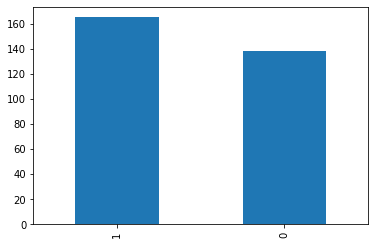

In [28]:
df['target'].value_counts().plot(kind='bar');

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [30]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [31]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


### Heart disease frequency according to sex

In [32]:
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [33]:
 pd.crosstab(df.target,df.sex)

sex,0,1
target,,
0,24,114
1,72,93


 In this,

    total female = 96
    affected female = 72 , one third of the female are affected
    
    total male = 207
    affected male = 93 half of the male are affected 

Text(0.5, 0, '0 = No heart disease  1 = heart disease')

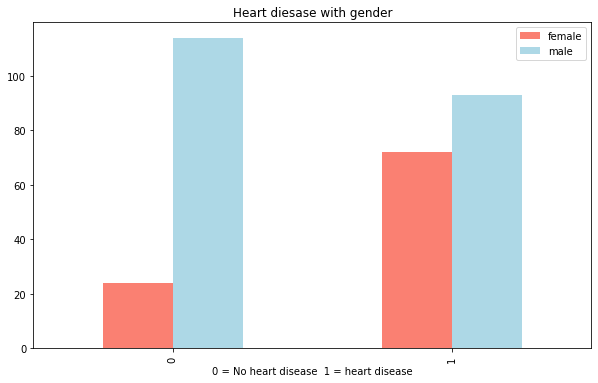

In [34]:
pd.crosstab(df.target,df.sex).plot(kind = "bar",color = ['salmon','lightblue'],figsize=(10,6));
    
plt.title("Heart diesase with gender")
plt.legend(['female','male'])
plt.xlabel("0 = No heart disease  1 = heart disease")

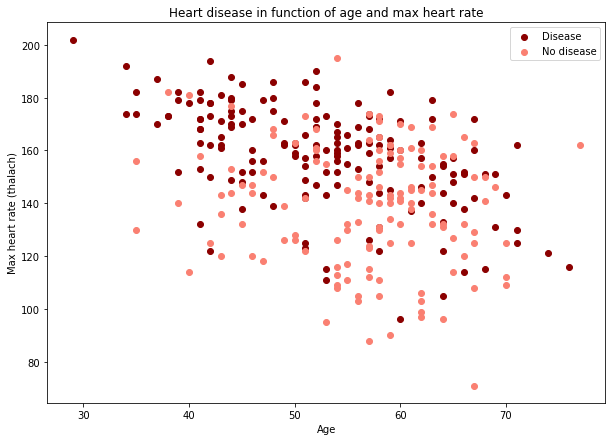

In [35]:
plt.figure(figsize=(10,7))

plt.scatter(df.age[df.target==1],
            df.thalach[df.target==1],
            c = 'darkred')

plt.scatter(df.age[df.target==0],
            df.thalach[df.target==0],
            c = 'salmon')

plt.title("Heart disease in function of age and max heart rate")
plt.xlabel('Age')
plt.ylabel('Max heart rate (thalach)')
plt.legend(['Disease','No disease'])

(array([ 1., 11., 33., 38., 37., 60., 63., 43., 14.,  3.]),
 array([29. , 33.8, 38.6, 43.4, 48.2, 53. , 57.8, 62.6, 67.4, 72.2, 77. ]),
 <a list of 10 Patch objects>)

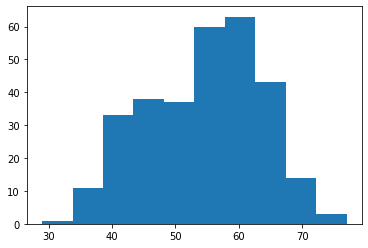

In [36]:
## check the distribution of the age column with hist
plt.hist(df.age)

### Heart disease frequency for chest pain

In [37]:
pd.crosstab(df.cp,df.target)

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


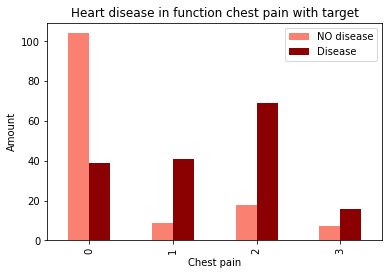

In [38]:
pd.crosstab(df.cp,df.target).plot(kind='bar',color=['salmon','darkred'])


plt.title("Heart disease in function chest pain with target")
plt.xlabel('Chest pain')
plt.ylabel('Amount')
plt.legend(['NO disease','Disease'])

### Building a correlation matrix

In [39]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


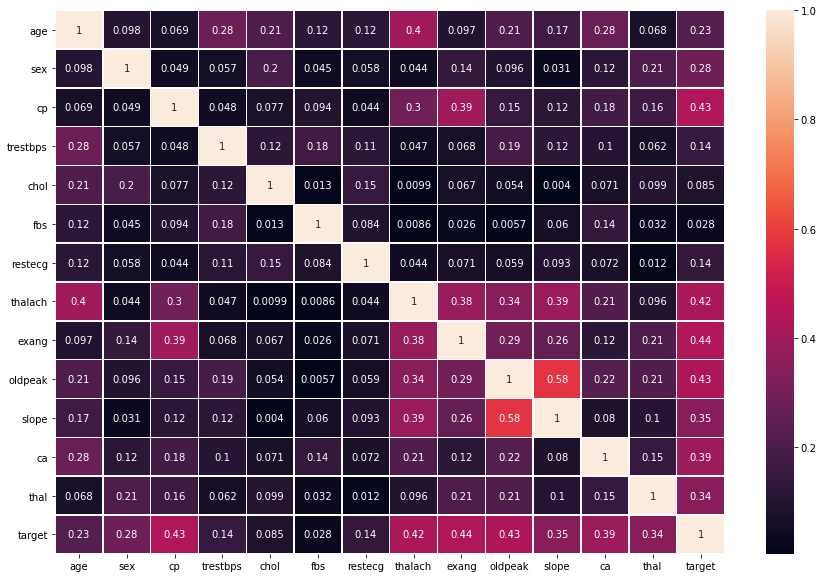

In [40]:
corr_mat = abs(df.corr())

plt.figure(figsize=(15,10))
sns.heatmap(corr_mat,annot=True,linewidths=0.5)

## Modelling

In [41]:
# split data into X and y

X = df.drop('target',axis=1)
y = df['target']

X = X.drop(['trestbps','restecg'],axis=1)

In [42]:
# train test spliting

np.random.seed(42) #To reproduced the randomized data again

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2)

X_train.shape , X_test.shape

((242, 11), (61, 11))

**Models to build**

1. RandomForestClassifier
2. Logistic Regression
3. KNearest neighbor classifier
4. a LightGBM model

In [43]:
# Time to build a machine learning model

models = {'logistic regression':LogisticRegression(),
          'Random forest classifier':RandomForestClassifier(),
          'KNearest neighbor':KNeighborsClassifier()
         }

np.random.seed(42)

def fit_and_score(models,X_train,X_test,y_train,y_test):
    """
    Fits and evaluatest different machine learning models.
    models : a dict of different sciit learn machine learning models.
    X_train : training data (no labels)
    X_test : Testing data (no labels)
    y_train : training labels
    y_test : testing labels    
    """
    scores = {}
    for name , model in models.items():
        model.fit(X_train,y_train)
        #scores[name] = model.score(X_test,y_test)
        scores[name] = metrics.roc_auc_score(y_test, model.predict(X_test))
    return scores
        

In [48]:
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_test,y_test)

param = {'num_leaves': 50, 'objective': 'binary'}
param['metric'] = 'auc'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

In [49]:
from sklearn import metrics
ypred = bst.predict(X_test)

score = metrics.roc_auc_score(y_test, ypred)
model_scores = fit_and_score(models=models,X_train=X_train,X_test=X_test,
                             y_train=y_train,y_test=y_test)

print(f"Test of lgb model - AUC score: {score}")
print(model_scores)

Test of lgb model - AUC score: 0.9294181034482758
{'logistic regression': 0.8841594827586207, 'Random forest classifier': 0.8512931034482758, 'KNearest neighbor': 0.654094827586207}


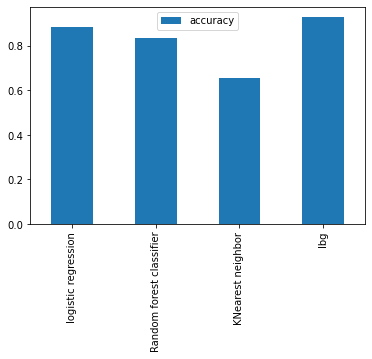

In [46]:
model_scores['lbg']= score
model_scores_df = pd.DataFrame(model_scores,index=['accuracy'])
model_scores_df.T.plot.bar();
